In [1]:
import geopandas as gpd
import numpy as np
import os
import rasterio as rio
from rasterio import * 
from rasterio.plot import show
from shapely.geometry import box
from fiona.crs import from_epsg
import fiona
import rasterio.mask
from shapely.geometry import MultiPolygon, Point
from rasterio.mask import mask

## From earthdatascience
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import shapely

C:\Users\VMO\anaconda3\envs\earth\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
### Script overview: Creating settlement areas based on settlements, population and admin

# Loading settlements, population and admin

# Subsetting the data for trial and development

# Adding hard boundaries to population data

# Creating a cost distance raster from population+admin raster

# Vectorize cost categories


### Setting up work environment

In [3]:
os.chdir(r'D:\iMMAP\proj\ASDC\data\sett_workspace')
print(os.getcwd())

D:\iMMAP\proj\ASDC\data\sett_workspace


### Loading settlements, population and admin

In [4]:
# Load data
sett = gpd.read_file('afg_pplp_subset_proj.shp')
admin = gpd.read_file('afg_adm2_new_proj.shp')
pop = rio.open('pop_clipped_qgis.tif', masked=True)
bbox = gpd.read_file('bbox.shp')


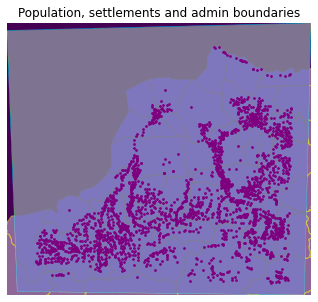

In [5]:
# Overlay and show all data
f, ax = plt.subplots(figsize=(10, 5))

admin.plot(ax=ax, color='white', edgecolor='yellow', alpha=.4)
sett.plot(ax=ax, color='red', markersize=3, alpha=1)
bbox.plot(ax=ax, color='blue', markersize=3, alpha=0.5)
show((pop, 1), ax=ax)

ax.set(title="Population, settlements and admin boundaries")

ax.set_axis_off()
plt.show()

### Clipping the data

In [6]:
# Clip admin
admin_clipped = gpd.clip(admin, bbox)

# Ignore missing/empty geometries
admin_clipped = admin_clipped[~admin_clipped.is_empty]

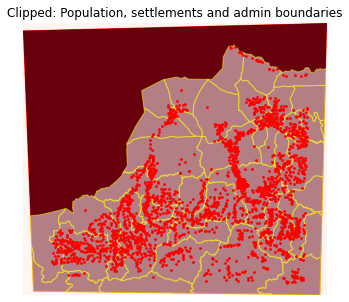

In [7]:
# Visualize clipped data
f, ax = plt.subplots(figsize=(10, 5))

admin_clipped.plot(ax=ax, color='white', edgecolor='yellow', markersize=3, alpha=0.5)
sett.plot(ax=ax, color='red', markersize=3, alpha=1)
#bbox.plot(ax=ax, color='blue', markersize=3, alpha=0.5)
show((pop, 1), cmap='Reds', ax=ax)

ax.set(title="Clipped: Population, settlements and admin boundaries")

ax.set_axis_off()
plt.show()

### Adding hard boundaries to population data

Convert geometries to lines and then rasterize

C:\Users\VMO\AppData\Local\Temp\ipykernel_8212\252298016.py:9: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in boundary:


<AxesSubplot:>

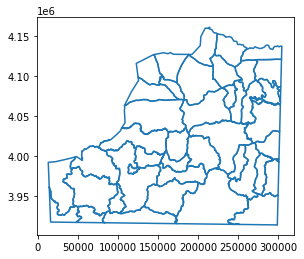

In [8]:
# Turn rows in geodataframe into list of linestrings

lines = []
for x in range(len(admin_clipped.index)):
    
    geometry = admin_clipped.iloc[x].geometry    #gets a polygon from each row (i.e. object) in geodataframe
    boundary = geometry.boundary                 #turns polygon into linestring 
    if boundary.type == 'MultiLineString':
        for line in boundary:
            lines.append(line)
    else:
        lines.append(boundary)

# Convert linestring to geoseries
admin_lines = gpd.GeoSeries(lines)
admin_lines.plot()




In [9]:
# Saving admin_lines to file
admin_lines.to_file("admin_lines.shp")

C:\Users\VMO\anaconda3\envs\earth\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
admin_lines = gpd.read_file("admin_lines.shp").buffer(100)


#admin_lines = gpd.read_file("buffered_lines_50.shp")


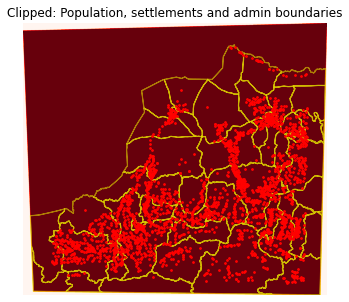

In [87]:
# Visualize clipped data
f, ax = plt.subplots(figsize=(10, 5))

admin_lines.plot(ax=ax, color='black', edgecolor='yellow', markersize=3, alpha=0.5)
sett.plot(ax=ax, color='red', markersize=3, alpha=1)
#bbox.plot(ax=ax, color='blue', markersize=3, alpha=0.5)
show((pop, 1), cmap='Reds', ax=ax)

ax.set(title="Clipped: Population, settlements and admin boundaries")

ax.set_axis_off()
plt.show()

In [11]:
# Get list of geometries for all features in vector file
geom = [shapes for shapes in admin_lines.geometry]

# Open example raster
raster = pop #rasterio.open(r"../_static/e_raster/bay-area-wells_kde_sklearn.tif")

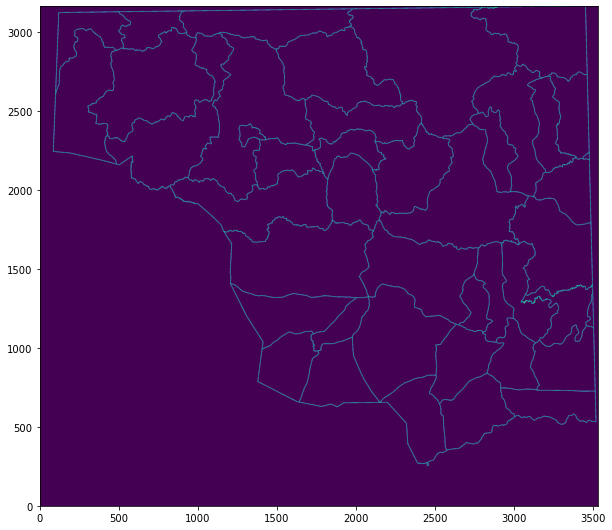

In [12]:
from rasterio import features

# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 99999999,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()


In [19]:
iteration = '11'

In [20]:
# Save raster with admin lines

with rasterio.Env():
    
    profile = pop.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open('admin_lines_v{}.tif'.format(iteration), 'w', **profile) as dst:
        dst.write(rasterized, 1) #pop_clipped[0][0].astype(rasterio.float32), 1)

In [21]:
# Open raster and check pixel values
adm = rio.open('admin_lines_v{}.tif'.format(iteration), masked=True)
adm_np = adm.read()

### Creating a cost distance raster from population+admin raster

Reverse population values so low pop = high cost

33.78012
0.01792169


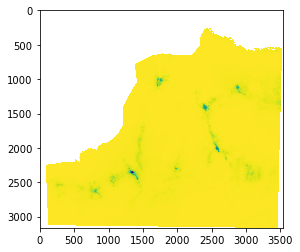

In [22]:
# Opening pop as numpy array
pop_np = pop.read()

# Removing nodata values from calculation
pop_np[(pop_np <= -99.0)] = np.nan 

print(np.nanmax(pop_np))
print(np.nanmin(pop_np))

# Conduct calculation to reverse values (("Rasterlayer" - Max_value) * -1) + Min_value
cost = ((pop_np - np.nanmax(pop_np)) * -1) + np.nanmin(pop_np)

# Check results
from matplotlib import pyplot as plt
plt.imshow(cost[0], interpolation='nearest')
plt.show()

In [23]:
## Convert reversed numpy back to raster to check results
#
#with rasterio.Env():
#    
#    profile = pop.profile
#
#    # And then change the band count to 1, set the
#    # dtype to uint8, and specify LZW compression.
#    profile.update(
#        dtype=rasterio.float32,
#        count=1,
#        compress='lzw')
#
#    with rasterio.open('pop_reversed_v06.tif', 'w', **profile) as dst:
#        dst.write(cost[0], 1) #pop_clipped[0][0].astype(rasterio.float32), 1)

Combine pop and admin into cost based numpy array / raster

In [24]:
# add admin boundaries to cost layer
cost_combined = cost + adm_np

#cost_combined[(cost_combined >= 1000.0)] = np.nan 

In [25]:

with rasterio.Env():
    
    profile = pop.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open('combined_cost_v{}.tif'.format(iteration), 'w', **profile) as dst:
        dst.write(cost_combined[0], 1) #pop_clipped[0][0].astype(rasterio.float32), 1)

##Running r.cost in python

In [11]:
from grass_session import Session
#import grass.script as gscript

RuntimeError: Cannot find GRASS GIS start script: 'grass', set the right one using the GRASSBIN environm. variable

### Vectorize cost categories